In [1]:
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("./twitter_new.csv")
train_df.head()

,post_text,label,split
0,try to have as good a life as you can under th...,0,train
1,realdonaldtrump full of yourself ? ? remember...,0,train
2,politicomag o man woman if we had mr . truman...,0,train
3,two and a half hours late to work,0,train
4,michael tarallo is now following me on twitter...,0,train


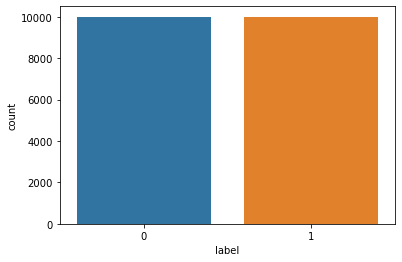

In [3]:
sns.countplot(train_df['label'])

In [4]:
train_df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in train_df['post_text']]

In [5]:
porter_stemmer = PorterStemmer()
train_df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in train_df['tokenized_text']]
train_df

,post_text,label,split,tokenized_text,stemmed_tokens
0,try to have as good a life as you can under th...,0,train,"[try, to, have, as, good, life, as, you, can, ...","[try, to, have, as, good, life, as, you, can, ..."
1,realdonaldtrump full of yourself ? ? remember...,0,train,"[realdonaldtrump, full, of, yourself, remember...","[realdonaldtrump, full, of, yourself, rememb, ..."
2,politicomag o man woman if we had mr . truman...,0,train,"[politicomag, man, woman, if, we, had, mr, tru...","[politicomag, man, woman, if, we, had, mr, tru..."
3,two and a half hours late to work,0,train,"[two, and, half, hours, late, to, work]","[two, and, half, hour, late, to, work]"
4,michael tarallo is now following me on twitter...,0,train,"[michael, tarallo, is, now, following, me, on,...","[michael, tarallo, is, now, follow, me, on, tw..."
...,...,...,...,...,...
19995,"i m glad i was able to defend myself , said a...",1,test,"[glad, was, able, to, defend, myself, said, yr...","[glad, wa, abl, to, defend, myself, said, yr, ..."
19996,thinking too much to sleep man this always hap...,1,test,"[thinking, too, much, to, sleep, man, this, al...","[think, too, much, to, sleep, man, thi, alwai,..."
19997,rt samstrike thanks for all the love this year...,1,test,"[rt, samstrike, thanks, for, all, the, love, t...","[rt, samstrik, thank, for, all, the, love, thi..."
19998,aartorias unless that s not what you meant,1,test,"[aartorias, unless, that, not, what, you, meant]","[aartoria, unless, that, not, what, you, meant]"


In [6]:
size = 500
window = 3
min_count = 1
workers = 3
# 0 for CBOW, 1 for skip-gram
sg = 0
OUTPUT_FOLDER = '/Users/sylnne/Documents/GitHub/twitter-sentiment-analysis/'
# Function to train word2vec model
def make_word2vec_model(train_df, padding, sg, min_count, size, workers, window):
    if  padding:
        #print(len(train))
        temp_df = pd.Series(train_df['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        #print(str(size))
        word2vec_file = OUTPUT_FOLDER + '2ata' + '_PAD.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(train_df, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

In [7]:
max_sen_len = train_df.stemmed_tokens.map(len).max()

padding_idx = w2vmodel.wv.vocab['pad'].index
print(padding_idx)
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

4269


In [8]:
max_sen_len

36

In [9]:
padding_idx

4269

In [10]:
def split_train_test(train_df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(train_df[['stemmed_tokens']], 
                                                        train_df['label'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(train_df)

Value counts for Train sentiments
0    7005
1    6995
Name: label, dtype: int64
Value counts for Test sentiments
1    3005
0    2995
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                     stemmed_tokens
0  16831  [larrydocu, my, entir, year, made, with, harri...
1  16015  [how, children, inherit, our, anxieti, http, c...
2  15380  [mittengirl, xo, veganrevoiut, someth, alreadi...
3    385  [adclaidekan, god, there, so, mani, good, on, ...
4  11825  [hollist, sk, uvedomil, som, si, swan, ceram, ...


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10

#torch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], 
#stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, 
#dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '2ata_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        # like a python list, it was designed to store any desired number of nn.Module
        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])
    
        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [13]:
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)

In [14]:
NUM_CLASSES = 2
VOCAB_SIZE = len(w2vmodel.wv.vocab)
print(VOCAB_SIZE)
cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)
num_epochs = 10

28471


In [15]:
# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []

cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0

    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        #print(Y_train['label'][index])
        target = make_target(Y_train['label'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()
        

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

    print(f'train_loss : {train_loss / len(X_train)}')
    print("Epoch ran :"+ str(epoch+1))
    
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
train_loss : 0.6714746914016348
Epoch ran :1
Epoch2
train_loss : 0.6492676782906055
Epoch ran :2
Epoch3
train_loss : 0.6411803438982794
Epoch ran :3
Epoch4
train_loss : 0.6359310652485916
Epoch ran :4
Epoch5
train_loss : 0.6330287629578795
Epoch ran :5
Epoch6
train_loss : 0.6303169460552079
Epoch ran :6
Epoch7
train_loss : 0.628464110574552
Epoch ran :7
Epoch8
train_loss : 0.6259397853889636
Epoch ran :8
Epoch9
train_loss : 0.6245042486701693
Epoch ran :9
Epoch10
train_loss : 0.6217808362117836
Epoch ran :10
Input vector
Probs
tensor([[0.4306, 0.5694]], grad_fn=<SoftmaxBackward0>)
1


Index(['iter', ' loss'], dtype='object')
[[2281  714]
 [1449 1556]]
              precision    recall  f1-score   support

           0       0.61      0.76      0.68      2995
           1       0.69      0.52      0.59      3005

    accuracy                           0.64      6000
   macro avg       0.65      0.64      0.63      6000
weighted avg       0.65      0.64      0.63      6000

Index(['iter', ' loss'], dtype='object')


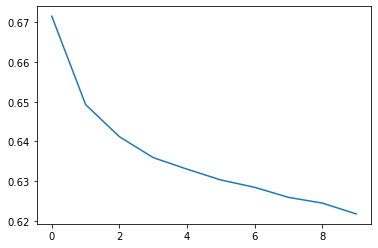

In [16]:
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        #print(row['stemmed_tokens'])
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        #print(bow_vec)
        probs = cnn_model(bow_vec)
        #print(probs.data)
        _, predicted = torch.max(probs.data,  1)
        
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['label'][index]).cpu().numpy()[0])

print(confusion_matrix(original_lables_cnn_bow, bow_cnn_predictions))
#print(original_lables_cnn_bow)
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER + '1cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER + '1loss_plt_500_padding_30_epochs.pdf')